# QVM/QKM comparison

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pickle
from sklearn.datasets import load_iris, load_wine
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.decomposition import PCA

from qiskit.circuit import ParameterVector
from qiskit_ibm_runtime.fake_provider import FakeManilaV2,FakeBrisbane,FakeKyoto,FakeOsaka
from qiskit_algorithms.optimizers import SPSA,COBYLA,ADAM

import warnings
warnings.filterwarnings("ignore")

from qiskit_aer import AerSimulator,Aer
from qiskit import QuantumCircuit, transpile
import time
from sklearn import svm
from qiskit_ibm_runtime import SamplerV2 as Sampler
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit.circuit.library import ZZFeatureMap
from qiskit_ibm_runtime import QiskitRuntimeService
# import os, json
from datetime import datetime
from pathlib import Path
import matplotlib as mpl
from cycler import cycler

## Parameters

In [2]:
# Global
data_name = 'wine'  # 'DP_NODP', 'iris', 'wine'
max_data_size = 150 # 150 default
n_qubits = 2 # There should be at most as many qubits as features in the dataset
APPLY_PCA = True

In [3]:
# QVM
OPTIMIZER = 'SPSA' # 'SPSA', 'COBYLA', 'ADAM'

In [4]:
# QKM
row_to_compare = 40 # Make sure there are at least that number of samples in TRAIN_DATA
idx_row_to_compare = row_to_compare - 1  # zero-based index

In [5]:
# Backend

"""
This part is about estimating the kernel with a real quantum computer
"""
# QiskitRuntimeService.save_account(channel="ibm_quantum", token="........8e5338f3752cf34eaa427........", overwrite=True, set_as_default=True)
# service = QiskitRuntimeService()
# backend = service.least_busy(operational=True, simulator=False)
# backend.name

"""
This part let us use a fake backend to test the code without using a real quantum computer
"""
backend =FakeOsaka()

## Load data

In [6]:
# constants
RANDOM_STATE = 42
if APPLY_PCA:
    pca = PCA(n_components=n_qubits)

def normalizeDataWine():
    """
    Normalizes the Wine data
    """
    wine = load_wine()

    # Uncomment for having two classes by mixing the third class with the first one (so you have the class 1 and the class "not 1" labeled as 0)
    # Comment for having only two classes by removing the third class
    # wine.target[wine.target == 2] = 0

    wine_two_classes = (wine.target < 2)

    if APPLY_PCA:
        X, Y = pca.fit_transform(wine.data[wine_two_classes]), wine.target[wine_two_classes]
    else:
        X, Y = wine.data[wine_two_classes][:, :n_qubits], wine.target[wine_two_classes] # X with only the first n_qubits features
    # shuffle the data
    X, Y = shuffle(X, Y, random_state=RANDOM_STATE)
    if max_data_size < len(X):
        X, Y = X[:max_data_size], Y[:max_data_size]

    # normalize the data
    scaler = MinMaxScaler(feature_range=(-0 * np.pi, 2 * np.pi))
    X = scaler.fit_transform(X)
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=RANDOM_STATE)
    return X_train, X_test, Y_train, Y_test

def normalizeDataIris():
    """
    Normalizes the Iris data
    """
    iris = load_iris()

    # Uncomment for having two classes by mixing the third class with the first one (so you have the class 1 and the class "not 1" labeled as 0)
    # Comment for having only two classes by removing the third class
    # iris.target[iris.target == 2] = 0

    iris_two_classes = (iris.target <2)

    if APPLY_PCA:
        X, Y = pca.fit_transform(iris.data[iris_two_classes]), iris.target[iris_two_classes]
    if n_qubits==2:
        X, Y = iris.data[iris_two_classes][:, 2:], iris.target[iris_two_classes] # X with only the last 2 features
    else:
        X, Y = iris.data[iris_two_classes][:, :n_qubits], iris.target[iris_two_classes] # X with only the first n_qubits features
    # shuffle the data
    X, Y = shuffle(X, Y, random_state=RANDOM_STATE)
    if max_data_size < len(X):
        X, Y = X[:max_data_size], Y[:max_data_size]

    # normalize the data
    scaler = MinMaxScaler(feature_range=(-0 * np.pi, 2 * np.pi))
    X = scaler.fit_transform(X)
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=RANDOM_STATE)
    return X_train, X_test, Y_train, Y_test

def normalizeDataImage(DATA_PATH = "./data/FEATURE_resultante_DP_NODP.csv"):
    """
    Normalizes the original images data
    """
    data = pd.read_csv(DATA_PATH)
    data = shuffle(data, random_state=RANDOM_STATE)
    if max_data_size < len(data):
        data = data[:max_data_size]
    
    if APPLY_PCA:
        X, Y = pca.fit_transform(data.values), data[' class'].values
    elif n_qubits==2:
        X, Y = data[['area_pixels', ' mean_coords_x']].values, data[' class'].values
    elif n_qubits==4:
        X, Y = data[['area_pixels', ' mean_coords_x', ' mean_coords_y', ' mean_intensity']].values, data[' class'].values
    else:
        X, Y = data[:, :n_qubits].values, data[' class'].values

    # normalize the data
    scaler = MinMaxScaler(feature_range=(-0 * np.pi, 2 * np.pi))
    X = scaler.fit_transform(X)
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=RANDOM_STATE)
    return X_train, X_test, Y_train, Y_test

if data_name == 'iris':
    TRAIN_DATA, TEST_DATA, TRAIN_LABELS, TEST_LABELS = normalizeDataIris()
elif data_name == 'wine':
    TRAIN_DATA, TEST_DATA, TRAIN_LABELS, TEST_LABELS = normalizeDataWine()
elif data_name == 'DP_NODP':
    TRAIN_DATA, TEST_DATA, TRAIN_LABELS, TEST_LABELS = normalizeDataImage()
print(TRAIN_DATA)

[[3.43735924 1.38887533]
 [4.53489598 0.98418699]
 [4.29140525 3.69071998]
 [3.77484579 2.6815118 ]
 [0.34647844 2.84093062]
 [1.55856605 4.66615624]
 [2.8556579  2.30149575]
 [0.33151702 1.53588506]
 [0.51083091 1.47418566]
 [3.30267648 1.28788975]
 [0.83001572 2.48159054]
 [1.93638239 1.84691554]
 [1.27253399 1.3920062 ]
 [1.55544096 1.89313107]
 [1.57772882 1.73686847]
 [4.55932408 2.80446244]
 [1.80080059 0.94431669]
 [4.66869008 0.43445252]
 [0.44790049 1.42667884]
 [1.80233348 2.17682641]
 [4.10898966 0.89590211]
 [2.54109487 1.59445086]
 [1.80250896 2.32624573]
 [3.59523493 2.3687226 ]
 [0.42069514 1.06342582]
 [3.16885821 1.76487126]
 [4.44576051 1.45183258]
 [0.97166477 0.9023308 ]
 [0.28679238 1.69866151]
 [3.1030771  3.02573066]
 [1.76507633 1.02686365]
 [5.38755558 1.97001287]
 [3.392812   1.69719349]
 [2.47613888 3.66376494]
 [0.69903643 1.56927819]
 [2.69916799 2.56263933]
 [0.59130497 1.4616777 ]
 [1.03874992 0.73488031]
 [3.52733622 1.72949875]
 [0.16604491 1.87793142]


## Filepaths

In [7]:
len_train_data = len(TRAIN_DATA)

In [8]:
# QVM
OPTIMIZATION_FILE_PATH = Path(f"results/QVM_OPTIMIZER_RESULTS/{data_name}_{len_train_data}TRAIN_{n_qubits}QB_{'PCA' if APPLY_PCA else 'NOPCA'}_optimization_{OPTIMIZER}_result.pkl")

In [9]:
# QKM
SAVED_SIMULATION_MATRIX=Path(f"./results/QKM_RESULTS/simulation_kernel_matrix_{data_name}_{len_train_data}TRAIN_{n_qubits}QB_{'PCA' if APPLY_PCA else 'NOPCA'}_TRAIN.npy")
SAVED_COUNTS_FILE_PATH = Path(f"./results/QKM_RESULTS/{data_name}_{len_train_data}TRAIN_{n_qubits}QB_{'PCA' if APPLY_PCA else 'NOPCA'}_fake_osaka_kernel_row{row_to_compare}_results_counts.txt")
SAVED_SIMULATION_MATRIX_TESTS=Path(f"./results/QKM_RESULTS/simulation_kernel_matrix_{data_name}_{len_train_data}TRAIN_{n_qubits}QB_{'PCA' if APPLY_PCA else 'NOPCA'}_TEST.npy")

In [10]:
# Comparison
SUMMARY_CSV = Path("./results/EXPERIMENT_RESULTS/summary.csv")

## Re-run

In [11]:
# QVM
RERUN_OPTIMIZATION = not(OPTIMIZATION_FILE_PATH.exists())

In [12]:
# QKM
RERUN_KERNEL_SIMULATION=not(SAVED_SIMULATION_MATRIX.exists())
RERUN_KERNEL_REAL=not(SAVED_COUNTS_FILE_PATH.exists())
RERUN_KERNEL_TESTS=not(SAVED_SIMULATION_MATRIX_TESTS.exists())

In [13]:
# Comparison
WRITE_CSV_ENTRY= RERUN_KERNEL_TESTS or RERUN_KERNEL_REAL or RERUN_KERNEL_SIMULATION or RERUN_OPTIMIZATION

In [14]:
print(f'Optimization re-runed: {RERUN_OPTIMIZATION}')
print(f'Train simulation re-runed: {RERUN_KERNEL_SIMULATION}')
print(f'Train real re-runed: {RERUN_KERNEL_REAL}')
print(f'Test simulation re-runed: {RERUN_KERNEL_TESTS}')
print(f'New entry written to CSV: {WRITE_CSV_ENTRY}')

Optimization re-runed: False
Train simulation re-runed: False
Train real re-runed: False
Test simulation re-runed: False
New entry written to CSV: False


## QVM

### Functions

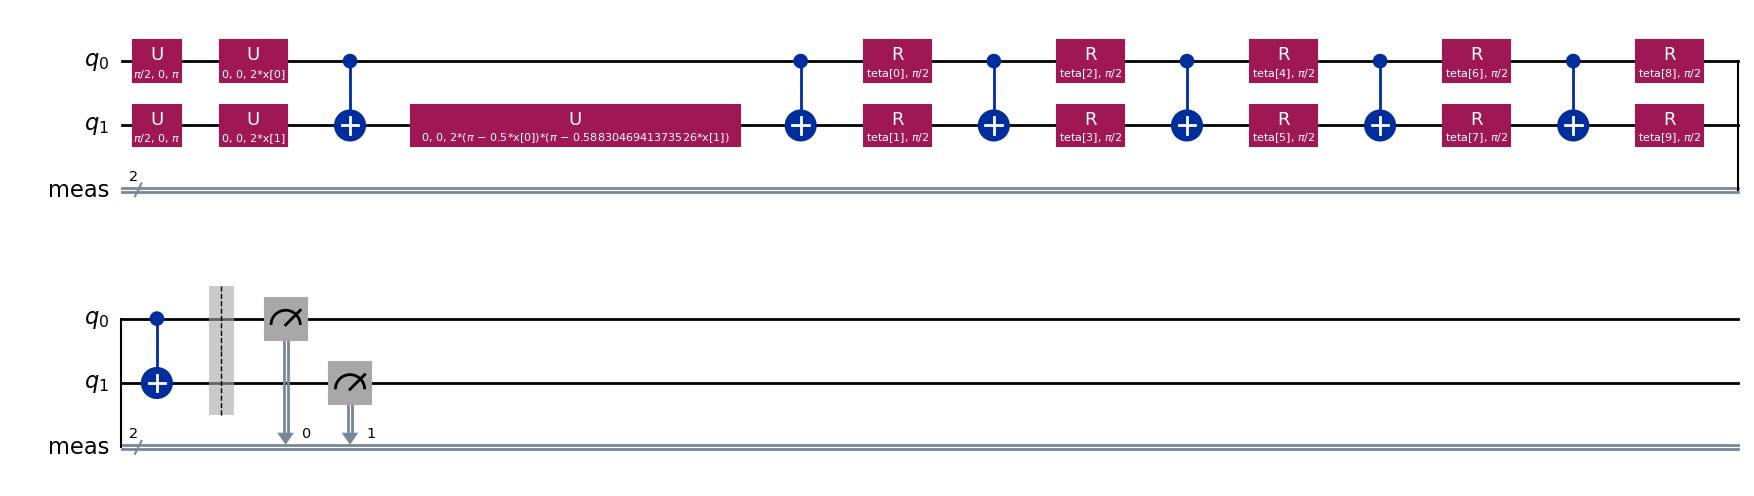

In [15]:
reps = 1                    # feature-map repetitions
ry_layers = 5               # number of per-qubit ry layers (controls len(teta))

x = ParameterVector('x', n_qubits)
teta = ParameterVector('teta', n_qubits * ry_layers)

def ZZFeatureMap_10_parametros(feature_dimension=n_qubits, reps=1, theta_param=np.pi/2, x=x, teta=teta):
    try:
        ptp = np.ptp(TRAIN_DATA, axis=0)
        factors = np.where(ptp == 0, 1.0, np.pi / ptp)[:feature_dimension]
    except Exception:
        factors = np.ones(feature_dimension)
    # if factors shorter, pad
    if len(factors) < feature_dimension:
        factors = np.pad(factors, (0, feature_dimension - len(factors)), 'edge')

    circuit = QuantumCircuit(feature_dimension)
    t_idx = 0  # index into teta

    for r in range(reps):
        if r == 0:
            circuit.h(range(feature_dimension))

        # encode each feature as a phase rotation
        for q in range(feature_dimension):
            circuit.p(theta_param * x[q], q)

        # simple chain entangling
        for q in range(feature_dimension - 1):
            circuit.cx(q, q + 1)

        # apply a multi-feature phase on the last qubit (generalized product)
        prod = 1.0
        for k in range(feature_dimension):
            prod *= (np.pi - x[k] * factors[k])
        circuit.p(theta_param * prod, feature_dimension - 1)

        # disentangle
        for q in range(feature_dimension - 1):
            circuit.cx(q, q + 1)

        # apply ry layers parameterized by teta, with entangling between layers
        for layer in range(ry_layers):
            for q in range(feature_dimension):
                circuit.ry(teta[t_idx], q)
                t_idx += 1
            # add entangling between ry layers (chain)
            for q in range(feature_dimension - 1):
                circuit.cx(q, q + 1)

    circuit.measure_all()
    return circuit

# create feature_map and reference feature map for overlaps
feature_map = ZZFeatureMap_10_parametros(feature_dimension=n_qubits, reps=reps, theta_param=2, x=x, teta=teta)
# zz_feature_map_reference = ZZFeatureMap(feature_dimension=n_qubits, reps=reps)
# ...existing code...

feature_map.decompose().draw("mpl")

In [16]:
def classification_probability(data, variational):
    """Classify data points using given parameters.
    Args:
        data (list): Set of data points to classify
        variational (list): Parameters for `VAR_FORM`
    Returns:
    #results = execute(circuits, backend, shots=shots_per_execution).result()
    job = backend.run(circuits,shots=4000)
    #counts = job.result().get_counts()
    #######33
    results = job.result()
        list[dict]: Probability of circuit classifying
                    each data point as 0 or 1.
    shots_per_execution = 100"""
    shots_per_execution = 50
    circuits = [circuit_instance_MIO(d, variational) for d in data]
    #results = execute(circuits, backend, shots=shots_per_execution).result()
    #results = execute(circuits, backend, shots=shots_per_execution).result()
    job = backend.run(circuits,shots=100)
    #counts = job.result().get_counts()
    classification = [
        label_probability(job.result().get_counts(c)) for c in circuits]
    return classification

def parity(bitstring):
    """Returns 1 if parity of `bitstring` is even, otherwise 0."""
    hamming_weight = sum(int(k) for k in list(bitstring))
    return (hamming_weight+1) % 2

def label_probability(results):
    """Converts a dict of bitstrings and their counts,
    to parities and their counts"""
    shots = sum(results.values())
    probabilities = {0: 0, 1: 0}
    for bitstring, counts in results.items():
        label = parity(bitstring)
        probabilities[label] += counts / shots
    return probabilities

def cross_entropy_loss(classification, expected):

    p = classification.get(expected)  # Prob. of correct classification
    return -np.log(p + 1e-10)

def cost_function(data, labels, variational):
    """Evaluates performance of our circuit with `variational`
    parameters on `data`.

    Args:
        data (list): List of data points to classify
        labels (list): List of correct labels for each data point
        variational (list): Parameters to use in circuit

    Returns:
        float: Cost (metric of performance)
    """
    classifications = classification_probability(data, variational)
    cost = 0
    for i, classification in enumerate(classifications):
        cost += cross_entropy_loss(classification, labels[i])
    cost /= len(data)
    return cost

class OptimizerLog:
    """Log to store optimizer's intermediate results"""
    def __init__(self):
        self.evaluations = []
        self.parameters = []
        self.costs = []

    def update(self, parameter):
        """Save intermediate results."""
        evaluation = len(self.evaluations) + 1  # Assuming evaluations are sequential
        cost = objective_function(parameter)
        self.evaluations.append(evaluation)
        self.parameters.append(parameter)
        self.costs.append(cost)

def circuit_instance_MIO(data, variational):
    """Assigns parameter values to `AD_HOC_CIRCUIT`.
    Args:
        data (list): Data values for the feature map
        variational (list): Parameter values for `VAR_FORM`
    Returns:
        QuantumCircuit: `AD_HOC_CIRCUIT` with parameters assigned
    """

    return feature_map.assign_parameters({x:data,teta:variational})

def objective_function(variational):
    """Cost function of circuit parameters on training data.
    The optimizer will attempt to minimize this."""
    return cost_function(TRAIN_DATA, TRAIN_LABELS, variational)# clear objective value history

def comparar_probabilidades(probabilidades, labels):
    if len(probabilidades) != len(labels):
        raise ValueError("Lists of probabilities and labels must be the same length.")

    coincidencias = 0

    for prob_dict, label in zip(probabilidades, labels):
        # Get the class with the highest probability
        clase_predicha = max(prob_dict, key=prob_dict.get)

        # Check if the predicted class matches the actual label
        if clase_predicha == label:
            coincidencias += 1

    probabilidad_media = coincidencias / len(labels)
    return probabilidad_media

In [17]:
if RERUN_OPTIMIZATION:
        log = OptimizerLog()
        #optimizer = SPSA(maxiter=200,callback=callback_graph)
        if OPTIMIZER == 'SPSA':
                optimizer = SPSA(maxiter=100)
        #optimizer = SPSA(maxiter=50, learning_rate=0.05, perturbation=0.05)
        #optimizer=COBYLA(maxiter=40 rhobeg=2.0,callback=log.update)
        if OPTIMIZER == 'COBYLA':
                optimizer = COBYLA(maxiter=100,callback=log.update)
        if OPTIMIZER == 'ADAM':
                optimizer =ADAM(maxiter=100)
        #optimizer =ADAM(maxiter=5)
        #optimizer = SPSA(maxiter=50)

        # Run the optimization
        # bounds = [(0, 3), (0, 2)]
        # bounds = [(0, 1.1), (0, 1.1)]


        # Record the start time
        inicio_tiempo = time.time()
        
        ## initial point pre computed for repeatability
        if n_qubits * ry_layers == 10:
                initial_point=np.array([0.10125839, 2.18830448, 4.16274186, 3.3403106, 2.35531117, 0.43235425,
                        3.43275685, 1.82333407, 1.82281728, 3.01886616])
        elif n_qubits * ry_layers == 20:
                initial_point=np.array([3.34831588, 5.33036554, 0.56985979, 3.96093499, 5.1780918,  4.69458454,
                                        4.36380067, 2.09400526, 4.17059256, 0.7365267,  0.50770812, 6.1221038,
                                        4.56453325, 0.40735552, 0.41054564, 3.79755224, 3.99395733, 2.30598869,
                                        4.38139765, 1.50969987])
        else:
                initial_point=np.random.rand(n_qubits * ry_layers)*2*np.pi
                print(initial_point)
        
        result = optimizer.minimize(objective_function, initial_point)

        # Record the completion time
        fin_tiempo = time.time()
        # Calculate the time difference
        tiempo_ejecucion = fin_tiempo - inicio_tiempo
        # Print the execution time
        print(f"Time of the execution: {tiempo_ejecucion} s")

        print(result)

        with open(OPTIMIZATION_FILE_PATH, "wb") as f:
                pickle.dump(result, f)
else:
        with open(OPTIMIZATION_FILE_PATH, "rb") as f:
                result = pickle.load(f)

        print("Recovered result:", result)

Recovered result: {   'fun': np.float64(0.6332736030293604),
    'jac': None,
    'nfev': 200,
    'nit': 100,
    'njev': None,
    'x': array([ 2.00940933,  2.65659684,  6.12041576,  2.94735541,  1.05305309,
       -1.00898659,  3.94357288,  5.22160701,  2.55760054,  6.08065961])}


In [18]:
opt_var=result.x
print(f"Opt var : {opt_var}")

""" In this final part we can calculate the accuracy with this set of parameters after the optimization process.
"""
qvm_train_accuracy = comparar_probabilidades(classification_probability(TRAIN_DATA,opt_var), TRAIN_LABELS)

print(f"The average probability of matching is for train : {qvm_train_accuracy}")

qvm_test_accuracy = comparar_probabilidades(classification_probability(TEST_DATA,opt_var), TEST_LABELS)
print(f"The average probability of matching is for test : {qvm_test_accuracy}")


Opt var : [ 2.00940933  2.65659684  6.12041576  2.94735541  1.05305309 -1.00898659
  3.94357288  5.22160701  2.55760054  6.08065961]
The average probability of matching is for train : 0.6538461538461539
The average probability of matching is for test : 0.5384615384615384


## QKM

### Functions

In [19]:
size_of_plot=len(TRAIN_DATA)

In [20]:
zz_feature_map_reference = ZZFeatureMap(feature_dimension=n_qubits, reps=1)

zz_feature_map_reference.decompose().draw()

┌───┐┌───────────┐                                        
q_0: ┤ H ├┤ P(2*x[0]) ├──■──────────────────────────────────■──
     ├───┤├───────────┤┌─┴─┐┌────────────────────────────┐┌─┴─┐
q_1: ┤ H ├┤ P(2*x[1]) ├┤ X ├┤ P(2*(π - x[0])*(π - x[1])) ├┤ X ├
     └───┘└───────────┘└───┘└────────────────────────────┘└───┘

In [21]:
def scalar_product(circuit, x, y):
    """Compute statevector probs of composed feature_map(y) ∘ inverse_feature_map(x),
    appending the composed circuit to the provided `circuit` (in-place)."""
    zz_y = zz_feature_map_reference.assign_parameters(y)
    zz_x = zz_feature_map_reference.assign_parameters(x)
    composed = zz_y.compose(zz_x.inverse())

    # Append composed circuit to the provided container circuit on all qubits.
    circuit.append(composed.to_instruction(), range(n_qubits))

    sim_backend = Aer.get_backend('statevector_simulator')
    t_qc = transpile(circuit, sim_backend)
    result = sim_backend.run(t_qc).result()
    statevector = result.get_statevector(circuit)
    probs = np.abs(statevector) ** 2
    return probs

def kernel_gram_matrix_full(X1, X2):
    print("Calculating Gram matrix")

    gram_matrix = np.zeros((X1.shape[0], X2.shape[0]))
    for i, x1 in enumerate(X1):
        print(int(i / len(X1) * 100), "%")
        for j, x2 in enumerate(X2):
            qc = QuantumCircuit(n_qubits, n_qubits)
            x1 = x1.flatten()
            x2 = x2.flatten()
            prob = scalar_product(qc, x1, x2)[0]  #Use only the probability of state '00'
            gram_matrix[i, j] = prob

    return gram_matrix


#If the matrix is ​​square, this is easier.
# the dimension of x1 and x2 are equal
def kernel_gram_matrix_full_symmetric(X1, X2):
    print("Calculando matriz de Gram")

    num_samples_X1 = X1.shape[0]


    gram_matrix = np.zeros((num_samples_X1, num_samples_X1))  # Make sure you have the correct size

    # Calculate only the upper half of the matrix
    for i in range(num_samples_X1):
        print(int(i / num_samples_X1 * 100), "%")
        for j in range(i, num_samples_X1):  # Only calculate the top half
            qc = QuantumCircuit(n_qubits, n_qubits)
            x1 = X1[i].flatten()
            x2 = X2[j].flatten()

            prob = scalar_product(qc, x1, x2)[0]
            gram_matrix[i, j] = prob
            gram_matrix[j, i] = prob  # Symmetry: assigning the same value to the lower half

    return gram_matrix

def visualize_kernel_matrix(kernel_matrix):
    plt.imshow(kernel_matrix, cmap='viridis', interpolation='none', origin='lower', extent=[0, len(kernel_matrix), 0, len(kernel_matrix)])
    cbar = plt.colorbar(label='kernel matrix value')
    cbar.ax.yaxis.set_tick_params(labelsize=12)
    cbar.set_label('kernel matrix value', weight='bold', fontsize=14)
    plt.title('Kernel Matrix Visualization', fontweight='bold', fontsize=16)
    plt.xlabel('Data Index (X1)', fontweight='bold', fontsize=14)
    plt.ylabel('Data Index (X2)', fontweight='bold', fontsize=14)

    # Aumentar el tamaño y poner en negrita los números de los ejes
    plt.xticks(fontsize=12, fontweight='bold')
    plt.yticks(fontsize=12, fontweight='bold')

    plt.show()

def make_overlap_circuit(x, y):
    """Return composed feature_map(y) ∘ inverse_feature_map(x) with measurements."""
    zz_y = zz_feature_map_reference.assign_parameters(y)
    zz_x = zz_feature_map_reference.assign_parameters(x)
    zzinv = zz_x.inverse()
    # circ = zz_y.compose(zzinv, qubits=[0, 1])   # adjust qubits for n_qubits
    circ = zz_y.compose(zzinv)   # compose on all qubits
    circ.measure_all()
    return circ

def compute_accuracy(predictions, labels):
    correct = 0
    data_size = len(labels)
    for i in range(data_size):
        if predictions[i] == labels[i]:
            correct += 1
    accuracy = correct / data_size
    return accuracy

### Simulation

We compute the kernel matrix using statevector simulation.

- **Deterministic**: The result is exact and reproducible, unlike real quantum hardware, which is probabilistic.
- **No Noise**: Statevector simulations do not account for quantum noise or errors, which are present in real quantum devices.
- **Resource-Intensiv**e: Simulating large quantum circuits (many qubits) becomes computationally expensive because the statevector size grows exponentially with the number of qubits.

In [22]:
matrix_simetrica=[]
if RERUN_KERNEL_SIMULATION:
    inicio_tiempo = time.time()
    matrix_simetrica = kernel_gram_matrix_full_symmetric(TRAIN_DATA, TRAIN_DATA)
    fin=time.time()
    tiempo=inicio_tiempo-fin
    print(tiempo)
    # Save the matrix to a .npy file
    np.save(SAVED_SIMULATION_MATRIX, matrix_simetrica)
else:
    # Load the matrix from the .npy file
    matrix_simetrica=np.load(SAVED_SIMULATION_MATRIX, matrix_simetrica)

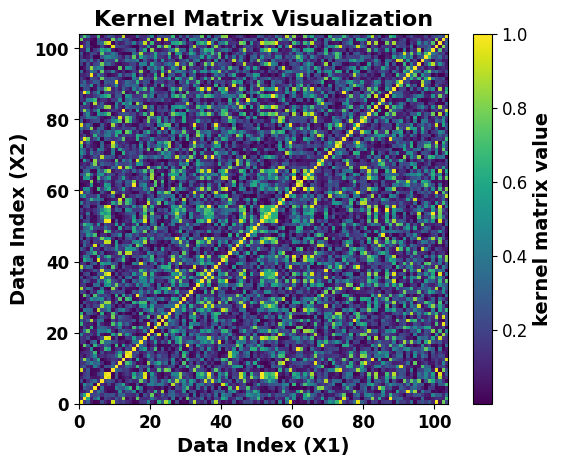

In [23]:
# Visualizar la matriz del kernel
visualize_kernel_matrix(matrix_simetrica)

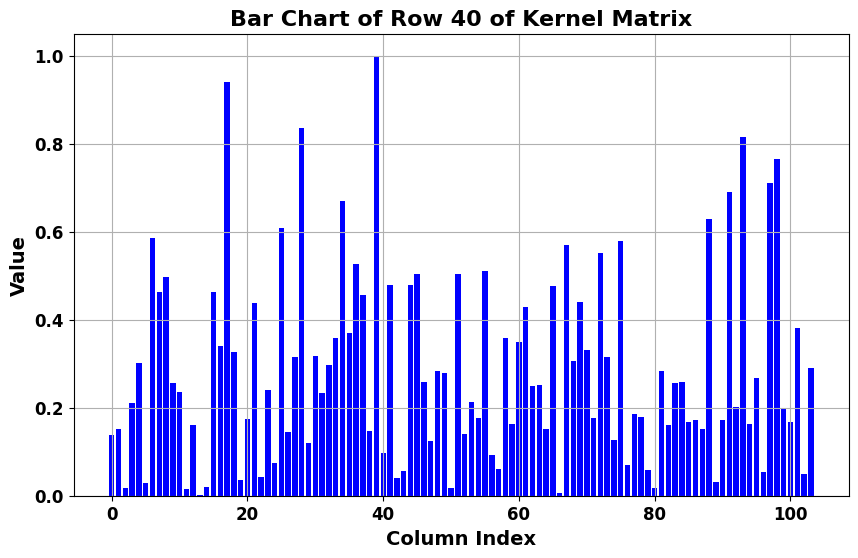

In [24]:
# Select row of the matrix
corresponding_sim_row = matrix_simetrica[idx_row_to_compare]

# Crear el diagrama de barras de la fila
plt.figure(figsize=(10, 6))
plt.bar(range(size_of_plot), corresponding_sim_row, color='b')
plt.title(f'Bar Chart of Row {row_to_compare} of Kernel Matrix', fontweight='bold', fontsize=16)
plt.xlabel('Column Index', fontweight='bold', fontsize=14)
plt.ylabel('Value', fontweight='bold', fontsize=14)
plt.xticks(fontsize=12, fontweight='bold')
plt.yticks(fontsize=12, fontweight='bold')
plt.grid(True)
plt.show()

### Hardware calculations
We run this time on (real or fake) quantum hardware

In [25]:
if RERUN_KERNEL_REAL:
    counts = []
    raw_circuits = []
    transpiled_circuits = []
    
    pairs_to_run = [(TRAIN_DATA[idx_row_to_compare].flatten(), TRAIN_DATA[j].flatten()) for j in range(len(TRAIN_DATA))]

    for (x, y) in pairs_to_run:
        raw_circuits.append(make_overlap_circuit(x.flatten(), y.flatten()))

    # now transpile all raw circuits for the backend once, storing order
    sim_noise = AerSimulator.from_backend(backend)   # uses target backend properties / noise
    passmanager = generate_preset_pass_manager(optimization_level=3, backend=sim_noise)
    transpiled_circuits = [passmanager.run(c) for c in raw_circuits]

    # submit transpiled_circuits to Sampler (order preserved)
    sampler = Sampler(backend)
    job = sampler.run(transpiled_circuits)
    result = job.result()

In [26]:
if RERUN_KERNEL_REAL:
    # Iterate over the results to print and save the counts
    counts_data = []
    with open(SAVED_COUNTS_FILE_PATH, 'w') as f:
        for idx, pub_result in enumerate(result):
            counts = pub_result.data.meas.get_counts()
            f.write(f"Counts for pub {idx}: {counts}\n")
            print(f" > Counts for pub {idx}: {counts}")
            counts_data.append(counts)
else:
    counts_data = []
    with open(SAVED_COUNTS_FILE_PATH, 'r') as f_read:
        for line in f_read:
            if line.startswith("Counts for pub"):
                # Extract the dictionary part from the line
                counts_str = line.split(":", 1)[1].strip()
                # Convert string dict to actual dict
                try:
                    counts = eval(counts_str)
                    counts_data.append(counts)
                except (SyntaxError, ValueError) as e:
                    print(f"Error parsing line: {line.strip()}")
                    print(e)

    print(f"Total circuits processed: {len(counts_data)}")

Total circuits processed: 104


In [27]:
#Extract the counts for '00' from each post and calculate the total sum of counts per post
counts_00 = []
str_to_find = '0'*n_qubits
for counts in counts_data:
    total_counts = sum(counts.values())
    count_00 = counts.get(str_to_find, 0)
    count_00_pu = count_00 / total_counts if total_counts != 0 else 0  # Evitar división por cero
    counts_00.append(count_00_pu)


#Print '00' counts in p.u. to verify
for idx, count in enumerate(counts_00):
    print(f"Counts of '00' in p.u. for pub {idx}: {count:.4f}")


Counts of '00' in p.u. for pub 0: 0.1328
Counts of '00' in p.u. for pub 1: 0.1523
Counts of '00' in p.u. for pub 2: 0.0225
Counts of '00' in p.u. for pub 3: 0.2188
Counts of '00' in p.u. for pub 4: 0.3242
Counts of '00' in p.u. for pub 5: 0.0518
Counts of '00' in p.u. for pub 6: 0.5762
Counts of '00' in p.u. for pub 7: 0.4434
Counts of '00' in p.u. for pub 8: 0.4883
Counts of '00' in p.u. for pub 9: 0.2686
Counts of '00' in p.u. for pub 10: 0.2295
Counts of '00' in p.u. for pub 11: 0.0312
Counts of '00' in p.u. for pub 12: 0.1914
Counts of '00' in p.u. for pub 13: 0.0127
Counts of '00' in p.u. for pub 14: 0.0322
Counts of '00' in p.u. for pub 15: 0.4736
Counts of '00' in p.u. for pub 16: 0.3447
Counts of '00' in p.u. for pub 17: 0.9102
Counts of '00' in p.u. for pub 18: 0.3018
Counts of '00' in p.u. for pub 19: 0.0537
Counts of '00' in p.u. for pub 20: 0.2021
Counts of '00' in p.u. for pub 21: 0.4141
Counts of '00' in p.u. for pub 22: 0.0547
Counts of '00' in p.u. for pub 23: 0.2363
Co

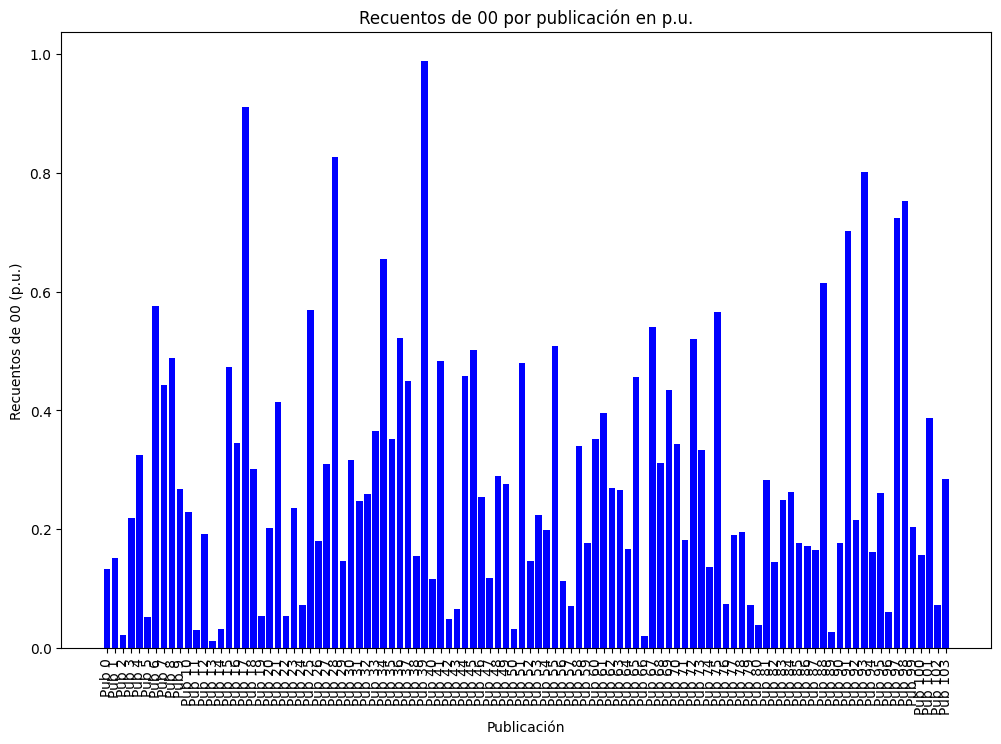

In [28]:
# Create the bar chart
fig, ax = plt.subplots(figsize=(12, 8))

# Define the indexes and values ​​for the chart
pub_indices = range(size_of_plot)

# Create the bars
ax.bar(pub_indices, counts_00[:size_of_plot], color='blue')

# Add tags and title
ax.set_xlabel('Publicación')
ax.set_ylabel('Recuentos de 00 (p.u.)')
ax.set_title('Recuentos de 00 por publicación en p.u.')
ax.set_xticks(pub_indices)
ax.set_xticklabels([f'Pub {i}' for i in pub_indices], rotation=90)

# Mostrar el gráfico
plt.show()

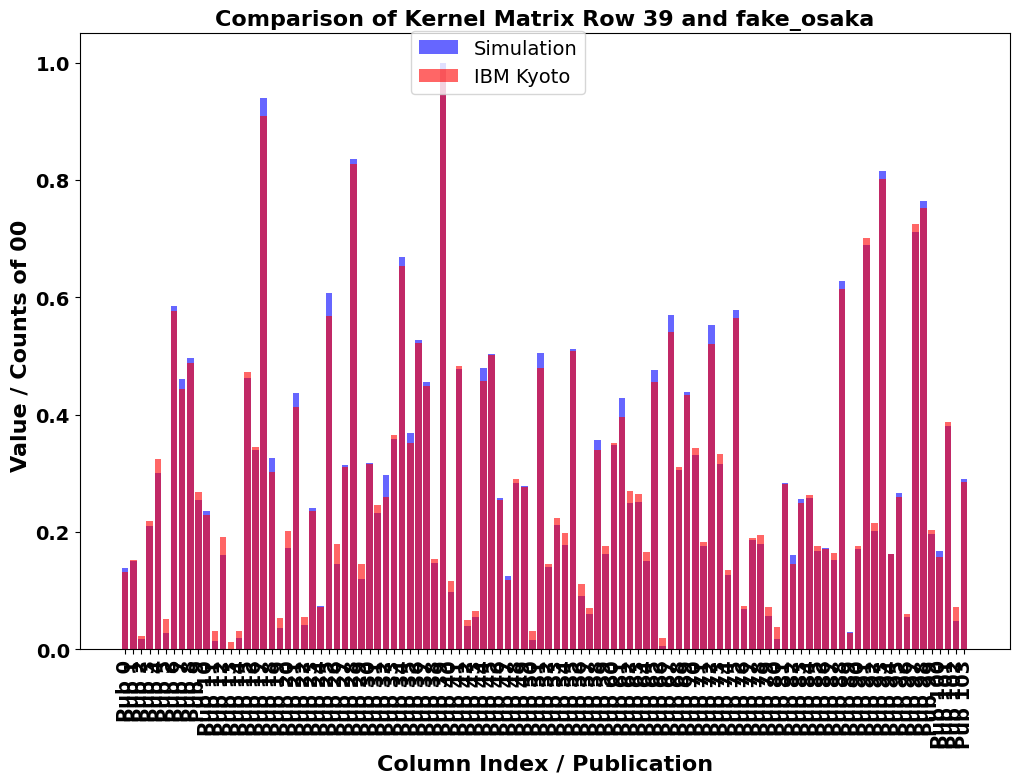

In [29]:
# Select tested row from the matrix
corresponding_sim_row = matrix_simetrica[idx_row_to_compare]

# Create the combined bar chart
fig, ax = plt.subplots(figsize=(12, 8))

# Define the indices for the plot
indices = range(size_of_plot)

# Create the bars for the corresponding row of the kernel matrix
ax.bar(indices, corresponding_sim_row, color='b', alpha=0.6, label='Simulation')

# Create the bars for the normalized counts of 00
ax.bar(indices, counts_00, color='r', alpha=0.6, label='IBM Kyoto')

# Add labels and title in bold and increase font size
ax.set_xlabel('Column Index / Publication', fontweight='bold', fontsize=16)
ax.set_ylabel('Value / Counts of 00 ', fontweight='bold', fontsize=16)
ax.set_title(f"Comparison of Kernel Matrix Row {idx_row_to_compare} and {backend.name}", fontweight='bold', fontsize=16)

# Modify the x-axis tick labels
ax.set_xticks(indices)
ax.set_xticklabels([f'Pub {i}' for i in indices], rotation=90, fontsize=14, fontweight='bold')

# Modify the y-axis tick labels
plt.yticks(fontsize=14, fontweight='bold')


ax.legend(loc='upper center', bbox_to_anchor=(0.45, 1.02), fontsize=14)
# Show the plot
plt.show()


In [30]:
print("Checking SVC with train...")

clf = svm.SVC(kernel="precomputed")
clf.fit(matrix_simetrica, TRAIN_LABELS)

#Record the start time
inicio_tiempo = time.time()
sol = clf.predict(matrix_simetrica)

success = 0

# Calculate the time difference
tiempo_ejecucion = time.time()- inicio_tiempo

print(f"Tiempo de ejecución: {tiempo_ejecucion} segundos")

Checking SVC with train...
Tiempo de ejecución: 0.0012388229370117188 segundos


In [31]:
clf = svm.SVC(kernel="precomputed")

# Fit the model to the training data
"""
finds the optimal hyperplane that separates the different classes based on the training data and the associated labels.
The objective function of the SVM is convex, meaning there are no local minima.
"""

start_time = time.time()
clf.fit(matrix_simetrica, TRAIN_LABELS)
training_time = time.time() - start_time
print("Tiempo de entrenamiento:", training_time, "segundos")

Tiempo de entrenamiento: 0.002287626266479492 segundos


In [32]:
qkm_train_accuracy = compute_accuracy(sol, TRAIN_LABELS)

print("Precisión del train: ", qkm_train_accuracy * 100, "%")

Precisión del train:  65.38461538461539 %


In [33]:
print("Comprobando con test...")
# Registra el tiempo de inicio
inicio_tiempo = time.time()

tests_matrix = []
if RERUN_KERNEL_TESTS:
    tests_matrix = kernel_gram_matrix_full(TEST_DATA, TRAIN_DATA)
    np.save(SAVED_SIMULATION_MATRIX_TESTS, tests_matrix)
else:
    tests_matrix = np.load(SAVED_SIMULATION_MATRIX_TESTS)

sol = clf.predict(tests_matrix)


# Calcula la diferencia de tiempo
tiempo_ejecucion = time.time()- inicio_tiempo

print(f"Tiempo de ejecución: {tiempo_ejecucion} segundos")

Comprobando con test...
Tiempo de ejecución: 0.003102540969848633 segundos


In [34]:
qkm_test_accuracy = compute_accuracy(sol, TEST_LABELS)

print("Precisión del test: ", qkm_test_accuracy * 100, "%")

Precisión del test:  65.38461538461539 %


## Comparison

In [35]:
if WRITE_CSV_ENTRY:
    # append summary row to CSV for quick aggregation
    df_row = pd.DataFrame([{
        'timestamp': datetime.now().isoformat(),
        'dataset': data_name,
        'n_train': int(TRAIN_DATA.shape[0]),
        'n_test': int(TEST_DATA.shape[0]),
        'n_features': int(TRAIN_DATA.shape[1]),
        'n_qubits': n_qubits,
        'with_pca': APPLY_PCA,
        'optimizer': OPTIMIZER,
        'qvm_train_acc': qvm_train_accuracy,
        'qvm_test_acc': qvm_test_accuracy,
        'qkm_train_acc': qkm_train_accuracy,
        'qkm_test_acc': qkm_test_accuracy
    }])

    if SUMMARY_CSV.exists():
        df_row.to_csv(SUMMARY_CSV, mode='a', header=False, index=False)
    else:
        df_row.to_csv(SUMMARY_CSV, index=False)
    print("Appended summary to", SUMMARY_CSV)

In [36]:
def plot_accuracy_by_experiment(df):
    # Plot accuracies (train/test) for QVM vs QKM for all experiments
    plt.figure(figsize=(16, 6))
    x = range(len(df))
    width = 0.18  # slightly smaller width for better separation

    # Define distinct base colors and subtle variations for train/test
    qvm_train_color = '#6baed6'  # lighter blue (QVM test)
    qvm_test_color  = '#1f77b4'  # blue (QVM train)
    qkm_train_color = '#fb9a99'  # lighter red (QKM test)
    qkm_test_color  = '#d62728'  # red (QKM train)
    # Set color cycle so subsequent plt.bar calls use these colors in order
    mpl.rcParams['axes.prop_cycle'] = cycler('color', [qvm_train_color, qvm_test_color, qkm_train_color, qkm_test_color])
    plt.bar([xi - 1.5*width for xi in x], df['qvm_train_acc'].fillna(0), width=width, label='QVM train acc')
    plt.bar([xi - 0.5*width for xi in x], df['qvm_test_acc'].fillna(0), width=width, label='QVM test acc')
    plt.bar([xi + 0.5*width for xi in x], df['qkm_train_acc'].fillna(0), width=width, label='QKM train acc')
    plt.bar([xi + 1.5*width for xi in x], df['qkm_test_acc'].fillna(0), width=width, label='QKM test acc')
    labels = df.apply(lambda r: f"{r['dataset']}_{r['n_train']}TRAIN_{r['n_qubits']}QB_{r['optimizer']}_{'PCA' if r['with_pca'] else 'NOPCA'}", axis=1)
    plt.xticks(x, labels, rotation=45, ha='right')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Per-experiment QVM vs QKM accuracy (train / test)')
    plt.tight_layout()
    plt.show()

def plot_qvm_minus_qkm_by_experiment(df):
    """Plot per-experiment accuracy difference (QVM - QKM) for train and test.
    Each experiment shows two bars (train, test). Experiments with PCA get a hatch pattern.
    """
    # compute differences
    df['diff_train'] = df['qvm_train_acc'] - df['qkm_train_acc']
    df['diff_test']  = df['qvm_test_acc'] - df['qkm_test_acc']

    # labels for x axis
    labels = df.apply(lambda r: f"{r['dataset']}_{r['n_train']}TRAIN_{r['n_qubits']}QB_{r['optimizer']}_{'PCA' if r['with_pca'] else 'NOPCA'}", axis=1)
    x = np.arange(len(df))
    width = 0.35

    # figure size adapts to number of experiments
    plt.figure(figsize=(16, 6))

    train_color = '#1f77b4'
    test_color  = '#d62728'

    bars_train = plt.bar(x - width/2, df['diff_train'].values, width, label='Train: QVM - QKM', color=train_color)
    bars_test  = plt.bar(x + width/2, df['diff_test'].values,  width, label='Test: QVM - QKM',  color=test_color)

    # # visually mark experiments that used PCA
    # if 'with_pca' in df.columns:
    #     for idx, used_pca in enumerate(df['with_pca'].astype(bool)):
    #         if used_pca:
    #             bars_train[idx].set_hatch('//')
    #             bars_test[idx].set_hatch('//')

    # reference zero line
    plt.axhline(0, color='k', linewidth=0.8, linestyle='--')

    # ticks/labels
    plt.xticks(x, labels, rotation=45, ha='right')
    plt.ylabel('Accuracy difference (QVM - QKM)')
    plt.title('Per-experiment QVM vs QKM accuracy difference (train / test)\n(positive value means QVM performs better)')
    plt.legend()

    # annotate bar values
    for bar in list(bars_train) + list(bars_test):
        h = bar.get_height()
        plt.annotate(f"{h:.3f}",
                        xy=(bar.get_x() + bar.get_width() / 2, h),
                        xytext=(0, 6 if h >= 0 else -10),
                        textcoords="offset points",
                        ha='center',
                        va='bottom' if h >= 0 else 'top',
                        fontsize=8)

    plt.tight_layout()
    plt.show()

def plot_accuracy_by_pca(df):
    # Differences in accuracy between QVM and QKM grouped by PCA usage
    df = df.copy()
    # Ensure boolean
    df['with_pca'] = df['with_pca'].astype(bool)

    # Aggregate mean accuracies per PCA setting
    group = df.groupby('with_pca').agg({
        'qvm_train_acc': 'mean',
        'qvm_test_acc': 'mean',
        'qkm_train_acc': 'mean',
        'qkm_test_acc': 'mean'
    }).sort_index()  # False (No PCA) first, True (PCA) second

    # Compute differences QVM - QKM for train and test
    diff_train = group['qvm_train_acc'] - group['qkm_train_acc']
    diff_test = group['qvm_test_acc'] - group['qkm_test_acc']

    # Prepare labels and plot
    labels = ['No PCA' if not idx else 'PCA' for idx in group.index]
    x = np.arange(len(labels))
    width = 0.35

    train_color = '#2ca02c'
    test_color  = '#ff7f0e'

    plt.figure(figsize=(7,4))
    bars1 = plt.bar(x - width/2, diff_train.values, width, label='Train: QVM - QKM', color=train_color)
    bars2 = plt.bar(x + width/2, diff_test.values, width, label='Test: QVM - QKM', color=test_color)

    # Zero line for reference
    plt.axhline(0, color='k', linewidth=0.8, linestyle='--')

    # Annotate bar values
    for b in bars1 + bars2:
        h = b.get_height()
        plt.annotate(f"{h:.3f}",
                     xy=(b.get_x() + b.get_width() / 2, h),
                     xytext=(0, 6 if h >= 0 else -10),
                     textcoords="offset points",
                     ha='center', va='bottom' if h >= 0 else 'top', fontsize=9)

    plt.xticks(x, labels)
    plt.ylabel('Accuracy difference\n(QVM - QKM)')
    plt.title('QVM vs QKM accuracy difference: PCA vs No PCA\n(positive value means QVM performs better)')
    plt.legend()
    plt.tight_layout()
    plt.show()

def plot_qvm_minus_qkm_by_optimizer(df):
    """Plot mean QVM - QKM accuracy difference grouped by optimizer (COBYLA, SPSA, ADAM).
    For each optimizer we show two bars: train and test.
    """
    # ensure diff columns exist
    df['diff_train'] = df['qvm_train_acc'] - df['qkm_train_acc']
    df['diff_test']  = df['qvm_test_acc']  - df['qkm_test_acc']

    # normalize optimizer strings and restrict to the three of interest
    df['optimizer_norm'] = df['optimizer'].astype(str).str.upper().str.strip()
    wanted = ['COBYLA', 'SPSA', 'ADAM']
    present = [o for o in wanted if o in df['optimizer_norm'].unique()]
    if not present:
        print("No COBYLA / SPSA / ADAM entries found in 'optimizer' column.")
        return

    # aggregate mean diff per optimizer
    agg = df[df['optimizer_norm'].isin(present)].groupby('optimizer_norm').agg({
        'diff_train': 'mean',
        'diff_test' : 'mean'
    }).reindex(present)  # keep canonical order

    labels = agg.index.tolist()
    x = np.arange(len(labels))
    width = 0.35

    train_color = '#e03be0'
    test_color  = "#2ca02c"

    plt.figure(figsize=(max(6, 3.5 * len(labels)), 6))
    bars_train = plt.bar(x - width/2, agg['diff_train'].values, width, label='Train: QVM - QKM', color=train_color)
    bars_test  = plt.bar(x + width/2, agg['diff_test'].values,  width, label='Test: QVM - QKM',  color=test_color)

    plt.axhline(0, color='k', linewidth=0.8, linestyle='--')
    plt.xticks(x, labels)
    plt.ylabel('Accuracy difference\n(QVM - QKM)')
    plt.title('Mean QVM vs QKM accuracy difference by optimizer\n(positive value means QVM performs better)')
    plt.legend()

    # annotate
    for b in list(bars_train) + list(bars_test):
        h = b.get_height()
        plt.annotate(f"{h:.3f}",
                        xy=(b.get_x() + b.get_width() / 2, h),
                        xytext=(0, 6 if h >= 0 else -10),
                        textcoords="offset points",
                        ha='center',
                        va='bottom' if h >= 0 else 'top',
                        fontsize=9)

    plt.tight_layout()
    plt.show()

def plot_qvm_minus_qkm_by_nqubits(df):
    """Plot mean QVM - QKM accuracy difference grouped by number of qubits.
    For each n_qubits we show two bars: train and test.
    """
    # check required columns
    required = {'qvm_train_acc','qvm_test_acc','qkm_train_acc','qkm_test_acc','n_qubits'}
    if not required.issubset(df.columns):
        missing = required - set(df.columns)
        print(f"Missing columns in dataframe: {missing}")
        return

    # compute differences
    df['diff_train'] = df['qvm_train_acc'] - df['qkm_train_acc']
    df['diff_test']  = df['qvm_test_acc']  - df['qkm_test_acc']

    # aggregate mean diff per number of qubits
    agg = df.groupby('n_qubits').agg({'diff_train':'mean','diff_test':'mean'}).sort_index()
    if agg.empty:
        print("No data after grouping by 'n_qubits'.")
        return

    labels = [f"{int(k)} qubits" for k in agg.index]
    x = np.arange(len(labels))
    width = 0.35

    train_color = "#d2e711"
    test_color  = "#0e26ff"

    plt.figure(figsize=(max(6, 3.5 * len(labels)), 6))
    bars_train = plt.bar(x - width/2, agg['diff_train'].values, width, label='Train: QVM - QKM', color=train_color)
    bars_test  = plt.bar(x + width/2, agg['diff_test'].values,  width, label='Test: QVM - QKM',  color=test_color)

    plt.axhline(0, color='k', linewidth=0.8, linestyle='--')
    plt.xticks(x, labels)
    plt.ylabel('Accuracy difference\n(QVM - QKM)')
    plt.title('Mean QVM vs QKM accuracy difference by number of qubits\n(positive value means QVM performs better)')
    plt.legend()

    # annotate bars
    for b in list(bars_train) + list(bars_test):
        h = b.get_height()
        plt.annotate(f"{h:.3f}",
                        xy=(b.get_x() + b.get_width() / 2, h),
                        xytext=(0, 6 if h >= 0 else -10),
                        textcoords="offset points",
                        ha='center',
                        va='bottom' if h >= 0 else 'top',
                        fontsize=9)

    plt.tight_layout()
    plt.show()

def plot_qvm_minus_qkm_by_ntrain(df):
    """Plot mean QVM - QKM accuracy difference grouped by number of training samples.
    For each n_train we show two bars: train and test.
    """
    required = {'qvm_train_acc','qvm_test_acc','qkm_train_acc','qkm_test_acc','n_train'}
    if not required.issubset(df.columns):
        missing = required - set(df.columns)
        print(f"Missing columns in dataframe: {missing}")
        return

    # compute differences
    df['diff_train'] = df['qvm_train_acc'] - df['qkm_train_acc']
    df['diff_test']  = df['qvm_test_acc']  - df['qkm_test_acc']

    # aggregate mean diff per training set size
    agg = df.groupby('n_train').agg({'diff_train':'mean','diff_test':'mean'}).sort_index()
    if agg.empty:
        print("No data after grouping by 'n_train'.")
        return

    labels = [f"{int(k)} samples" for k in agg.index]
    x = np.arange(len(labels))
    width = 0.35

    train_color = "#1f77b4"
    test_color  = "#ff7f0e"

    plt.figure(figsize=(max(6, 3.5 * len(labels)), 6))
    bars_train = plt.bar(x - width/2, agg['diff_train'].values, width, label='Train: QVM - QKM', color=train_color)
    bars_test  = plt.bar(x + width/2, agg['diff_test'].values,  width, label='Test: QVM - QKM',  color=test_color)

    plt.axhline(0, color='k', linewidth=0.8, linestyle='--')
    plt.xticks(x, labels, rotation=45, ha='right')
    plt.ylabel('Accuracy difference\n(QVM - QKM)')
    plt.title('Mean QVM vs QKM accuracy difference by training set size\n(positive value means QVM performs better)')
    plt.legend()

    # annotate bars
    for b in list(bars_train) + list(bars_test):
        h = b.get_height()
        plt.annotate(f"{h:.3f}",
                        xy=(b.get_x() + b.get_width() / 2, h),
                        xytext=(0, 6 if h >= 0 else -10),
                        textcoords="offset points",
                        ha='center',
                        va='bottom' if h >= 0 else 'top',
                        fontsize=9)

    plt.tight_layout()
    plt.show()

,timestamp,dataset,n_train,n_test,n_features,n_qubits,with_pca,optimizer,qvm_train_acc,qvm_test_acc,qkm_train_acc,qkm_test_acc
0,2025-10-18T15:34:51.104667,iris,80,20,2,2,True,COBYLA,0.625000,0.700000,0.687500,0.550000
1,2025-10-18T15:57:17.629989,iris,80,20,2,2,False,COBYLA,0.725000,0.900000,0.812500,0.800000
2,2025-10-18T22:40:01.394442,iris,80,20,2,2,False,SPSA,0.825000,0.850000,0.812500,0.800000
3,2025-10-24T20:37:24.377238,iris,80,20,4,4,False,COBYLA,0.637500,0.450000,1.000000,0.800000
4,2025-10-24T21:20:42.449374,iris,80,20,4,4,False,SPSA,0.625000,0.800000,1.000000,0.800000
5,2025-10-18T18:32:48.753980,wine,104,26,2,2,False,COBYLA,0.682692,0.615385,0.682692,0.653846
6,2025-10-18T18:33:53.157709,wine,104,26,2,2,True,COBYLA,0.692308,0.500000,0.653846,0.653846
7,2025-10-25T21:33:57.240705,wine,104,26,2,2,True,SPSA,0.663462,0.615385,0.653846,0.653846
8,2025-10-18T16:23:42.044228,DP_NODP,120,30,2,2,False,COBYLA,0.783333,0.700000,0.975000,0.966667
9,2025-10-18T21:50:56.107481,DP_NODP,120,30,2,2,False,SPSA,0.783333,0.833333,0.975000,0.966667


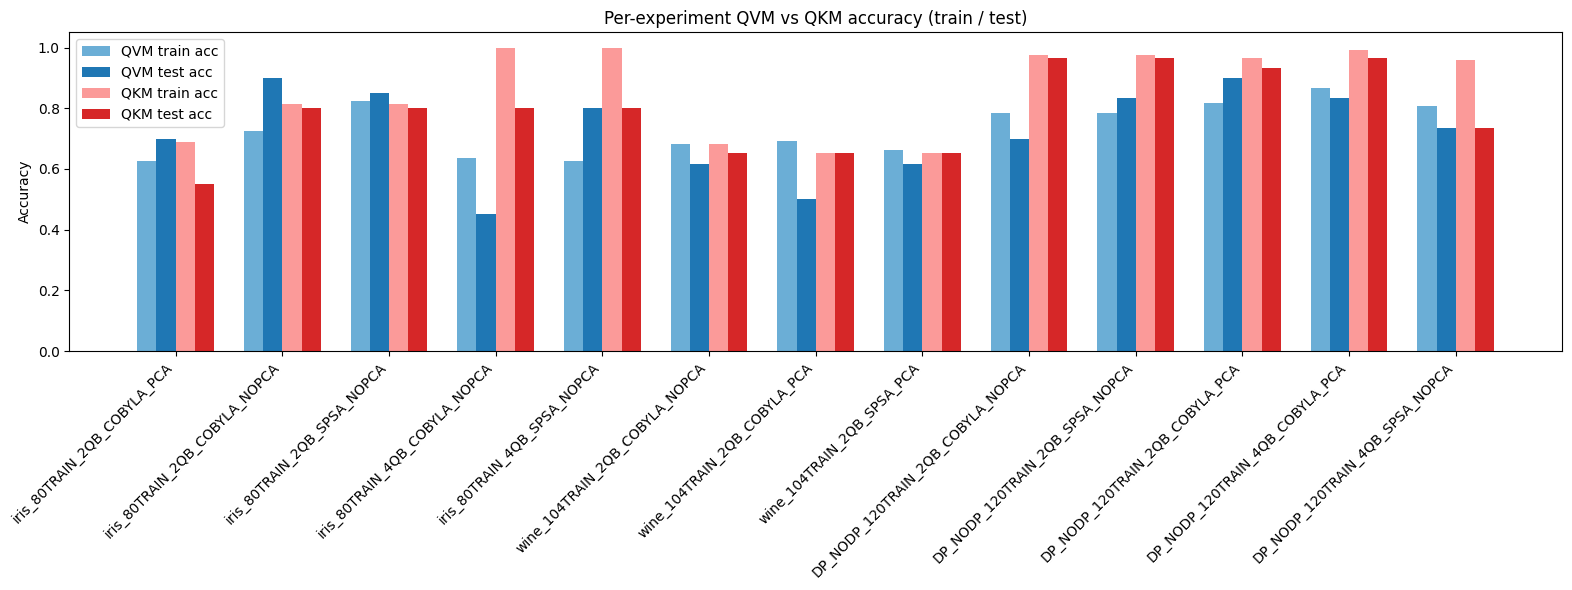

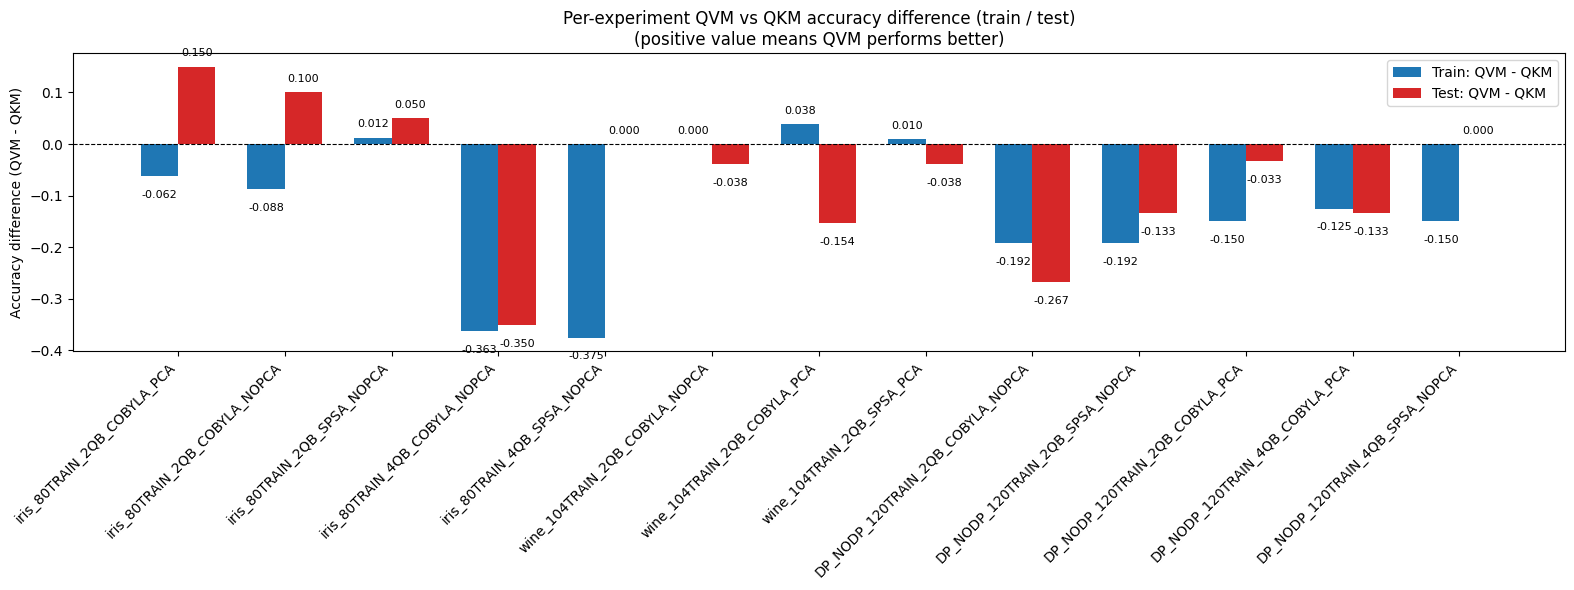

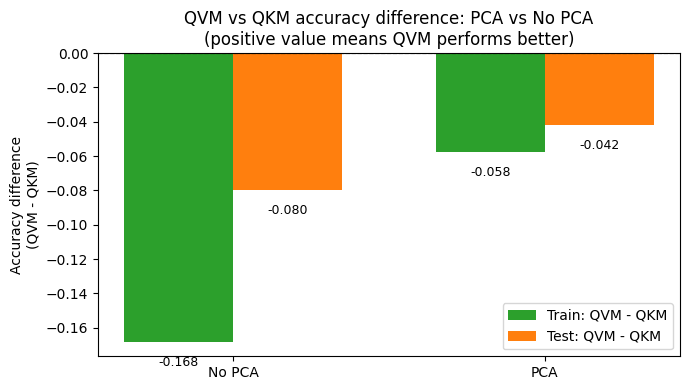

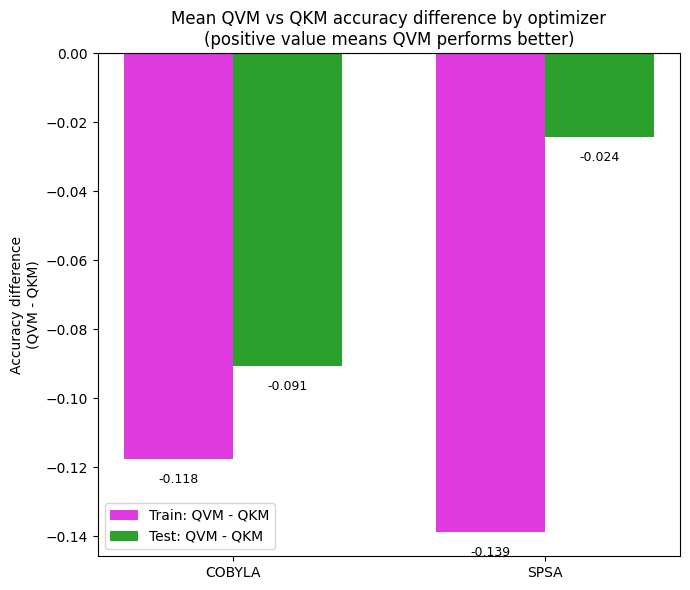

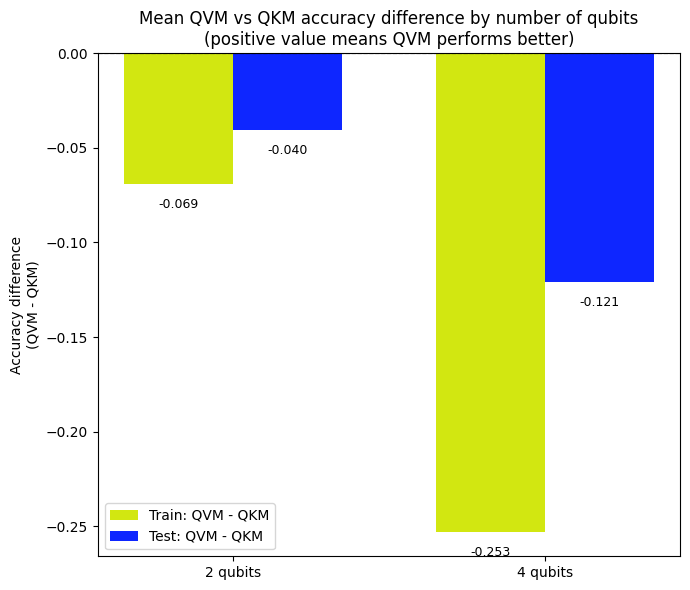

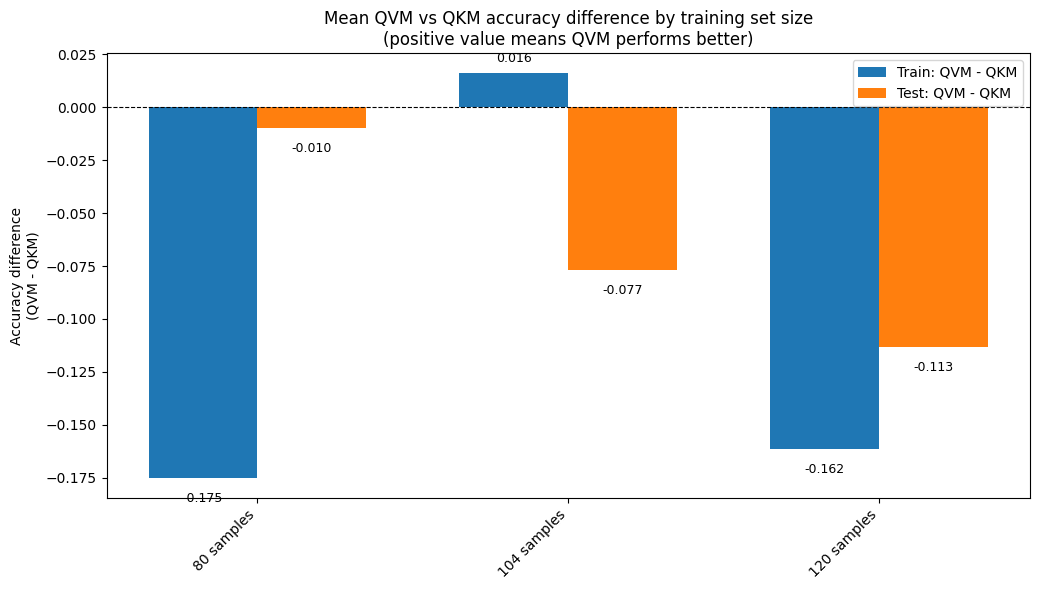

In [37]:
# Quick loader + plots to compare all saved experiments
def load_all_results_plot(summary_csv=SUMMARY_CSV):
    if not summary_csv.exists():
        print("No summary file found:", summary_csv)
        return
    df = pd.read_csv(summary_csv)
    display(df)  # notebook-friendly

    plot_accuracy_by_experiment(df.copy())

    plot_qvm_minus_qkm_by_experiment(df.copy())

    plot_accuracy_by_pca(df.copy())

    plot_qvm_minus_qkm_by_optimizer(df.copy())

    plot_qvm_minus_qkm_by_nqubits(df.copy())

    plot_qvm_minus_qkm_by_ntrain(df.copy())

# call loader to show current aggregated experiments
load_all_results_plot()